In [1]:
import numpy as np
import torch
import gymnasium as gym
from gymnasium import spaces

import imageio
import os
import random
import copy

#from Combined_Agent_Double.Dueling_DDQN_Agent import Dueling_DDQN_Agent
#from Combined_Agent_Double.utils.random_agent import RandomAgent
#from Combined_Agent_Double.utils.actions import MORE_ACTIONS
#import Combined_Agent_Double.utils.stats_functions as sf

from Agents.Prio_n_step.Prio_DQN_Agent import Prio_DQN_Agent
from Agents.Pablo.Adaptative_Dueling_Double_DQN.Agent import Adaptative_Dueling_Double_DQN
from Agents.Random.random_agent import RandomAgent
from Agents.utils.actions import MORE_ACTIONS
import Agents.utils.stats_functions as sf
import hockey.hockey_env as h_env

from Agents.Pablo.Agent import Dueling_DDQN_Agent
from Agents.Tapas_en_Mallorca.old.Agent import Combined_Agent
from Agents.Tapas_en_Mallorca.Adaptative_Dueling_Double_DQN.Agent import Adaptative_Dueling_Double_DQN_better_mem

from importlib import reload

In [2]:
SEED_TRAIN_1 = 7489
SEED_TRAIN_2 = 1312
SEEDS_TEST = [291 + i for i in range(10)]

seed = SEED_TRAIN_1

USE_MORE_ACTIONS = True

In [15]:
reload(h_env)
env_name = "../remake/Noisy_Dueling_Double_DQN_n_step_4_only_basic_remake_1/"
env = h_env.HockeyEnv()
h_env.HockeyEnv().seed(seed)
#env = gym.make("CartPole-v1", render_mode = "rgb_array")

state_space = env.observation_space

if(USE_MORE_ACTIONS):
    action_space = spaces.Discrete(len(MORE_ACTIONS))
else: 
    action_space = env.discrete_action_space

#agent = Adaptative_Dueling_Double_DQN_better_mem(state_space, action_space, seed = seed, eps = 0.01, learning_rate = 0.0001, hidden_sizes = [256, 256], n_steps = 5, env = env, use_more_actions = USE_MORE_ACTIONS)
agent = Adaptative_Dueling_Double_DQN(state_space, action_space, seed = seed,use_dueling = True, use_double = True, use_noisy = True ,eps = 0.01, learning_rate = 0.0001, hidden_sizes = [256, 256], env = env, use_more_actions = USE_MORE_ACTIONS)
#agent = Prio_DQN_Agent(state_space, action_space, seed = seed, eps = 0.01, learning_rate = 0.0001, hidden_sizes = [256, 256], n_steps = 5, env = env, use_more_actions = USE_MORE_ACTIONS)
agent.Q.load(env_name, name = "most_recent")

Dueling Network Architecture with Noisy Layers
  Input Layer: (18)
  Hidden Layer 1: Linear(18, 256) -> Tanh
  Hidden Layer 2: NoisyLinear(256, 256) -> Tanh
  Value Stream: Linear(256, 1)
  Advantage Stream: Linear(256, 20)
------------------------------------------------------
Dueling Network Architecture with Noisy Layers
  Input Layer: (18)
  Hidden Layer 1: Linear(18, 256) -> Tanh
  Hidden Layer 2: NoisyLinear(256, 256) -> Tanh
  Value Stream: Linear(256, 1)
  Advantage Stream: Linear(256, 20)
------------------------------------------------------
Network loaded from ../remake/Noisy_Dueling_Double_DQN_n_step_4_only_basic_remake_1//weights/most_recent.pth


/home/pablosbl/Documents/GitHub/hockey-en-mallorca/.venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment Hockey-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/pablosbl/Documents/GitHub/hockey-en-mallorca/.venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment Hockey-One-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/pablosbl/Documents/GitHub/hockey-en-mallorca/src/hockey-env/Agents/Pablo/Adaptative_Dueling_Double_DQN/QFunction.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models f

In [16]:
stats, losses = sf.load_stats(env_name)

Plot saved at ../remake/Noisy_Dueling_Double_DQN_n_step_4_only_basic_remake_1//stats/plots/returns_plot.png


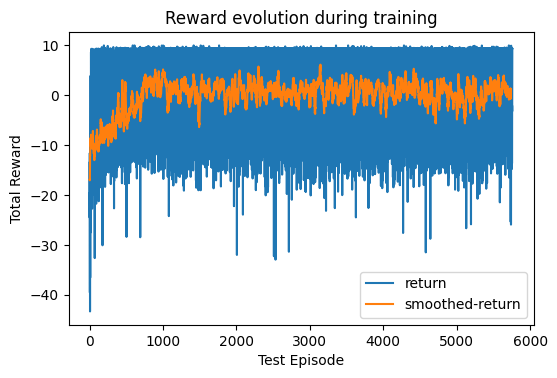

In [17]:
sf.plot_returns(stats, env_name)

Plot saved at ../remake/Noisy_Dueling_Double_DQN_n_step_4_only_basic_remake_1//stats/plots/losses_plot.png


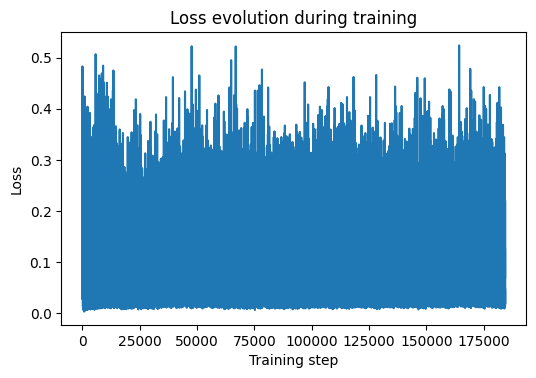

In [18]:
sf.plot_losses(losses, env_name)

In [19]:
#betas = sf.load_betas(env_name)
#sf.plot_beta_evolution(env_name, betas)

Plot saved at ../remake/Noisy_Dueling_Double_DQN_n_step_4_only_basic_remake_1//stats/plots/epsilon_evolution.png


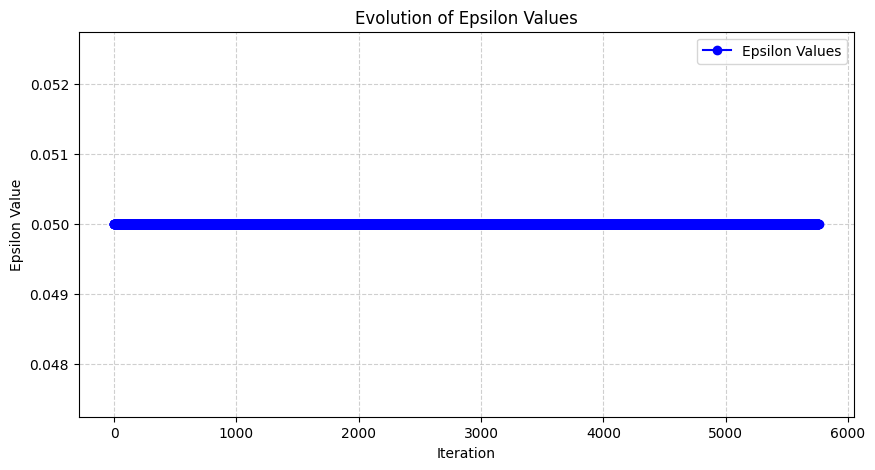

In [20]:
epsilons = sf.load_epsilons(env_name)
sf.plot_epsilon_evolution(env_name, epsilons)

Plot saved at ../remake/Noisy_Dueling_Double_DQN_n_step_4_only_basic_remake_1//stats/plots/match_evolution.png


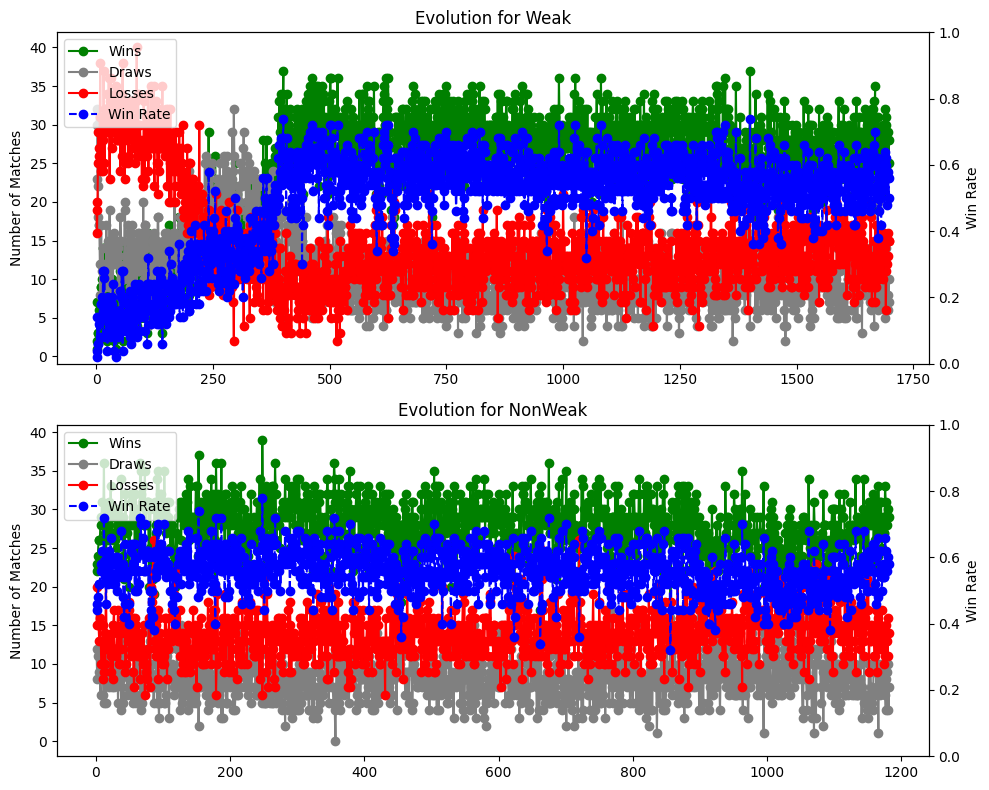

In [21]:
match_history = sf.load_match_history(env_name)
"""sf.plot_match_evolution_by_chunks(env_name, match_history,  [
    "Random",
    "Weak",
    "NonWeak",
    "Prio Agent_5000",
    "Prio_Agent_7500",
    "Combined Agent_5000",
    "Combined Agent_7500",
    "self_play",
], 50)"""

sf.plot_match_evolution_by_chunks(env_name, match_history,  ["Weak", "NonWeak"], 50)


In [35]:
def test_agent(agent = agent, opponent = RandomAgent(seed), test_episodes  = len(SEEDS_TEST), max_steps = 30000, opponent_name = "random", agent_name = "prio_agent", env_name = env_name):
   
    test_rewards = []
    test_name = f"{opponent_name}_vs_{agent_name}"
  

    for episode in range(test_episodes):

        obs_agent1, _ = env.reset(seed = SEEDS_TEST[episode])
        env.action_space.seed(seed)
        obs_agent1= obs_agent1[0] if isinstance(obs_agent1, tuple) else obs_agent1  # Handle Gymnasium compatibility

        obs_agent2 = env.obs_agent_two()
        obs_agent2 = obs_agent2[0] if isinstance(obs_agent2, tuple) else obs_agent2

        total_reward = 0

        frames = []
        
        for t in range(max_steps):

            done = False

            frame = env.render(mode = "rgb_array")
            if frame is not None:
                frames.append(frame)

            a1_cont = agent.get_step(obs_agent1)
            a2 = opponent.act(obs_agent2)

            full_action = np.hstack([a1_cont, a2])

            next_state, reward, done, truncated, _ = env.step(full_action)
            
            total_reward += reward

            obs_agent1 = next_state
            obs_agent2 = env.obs_agent_two()

            if done or truncated: break

        test_rewards.append(total_reward)
        print(f"Test Episode {episode+1}, Total Reward: {total_reward}")
        
        if frames:
            os.makedirs(f"{env_name}/test_gifs/{test_name}", exist_ok=True)
            imageio.mimsave(f"{env_name}/test_gifs/{test_name}/test_episode_{episode+1}.gif", frames, fps=30)

    env.close()
    results_name = f"test_results_{test_name}"
    sf.save_test_results(env_name, test_rewards, name = results_name)

Test Episode 1, Total Reward: 7.912606002205838
Test Episode 2, Total Reward: 9.507783297152484
Test Episode 3, Total Reward: -5.526717433646524
Test Episode 4, Total Reward: -12.772386960030738
Test Episode 5, Total Reward: 0.0
Test Episode 6, Total Reward: 4.367719914311797
Test Episode 7, Total Reward: 9.955286478219696
Test Episode 8, Total Reward: 9.30342562532791
Test Episode 9, Total Reward: 9.838116206885546
Test Episode 10, Total Reward: 9.586097666533819
Plot saved at ../remake/Noisy_Dueling_Double_DQN_n_step_4_only_basic_remake_1//stats/plots/test_results_random_vs_prio_agent.png


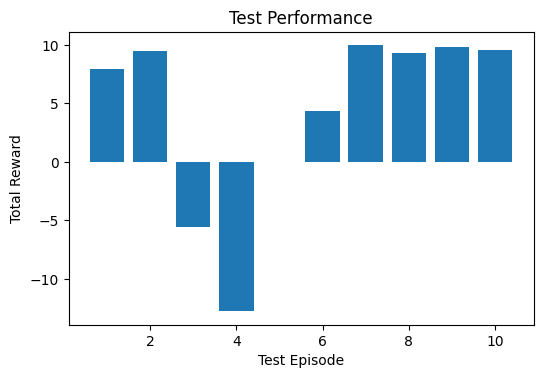

In [36]:
test_agent()

Test Episode 1, Total Reward: -11.717690731150356
Test Episode 2, Total Reward: 9.357167035966103
Test Episode 3, Total Reward: -3.1209251750575753
Test Episode 4, Total Reward: -11.85056788569134
Test Episode 5, Total Reward: -2.8890649435408005
Test Episode 6, Total Reward: 5.624327073198576
Test Episode 7, Total Reward: -14.12753359726629
Test Episode 8, Total Reward: 9.498787739971595
Test Episode 9, Total Reward: -11.758075900455303
Test Episode 10, Total Reward: -14.485125129982439
Plot saved at ../remake/Noisy_Dueling_Double_DQN_n_step_4_only_basic_remake_1//stats/plots/test_results_weak_vs_prio_agent.png


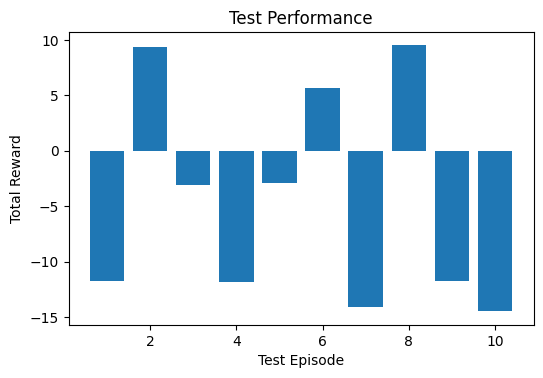

In [31]:
test_agent(opponent = h_env.BasicOpponent(weak=True), opponent_name = "weak", agent_name = "prio_agent")

Test Episode 1, Total Reward: -11.814189378106082
Test Episode 2, Total Reward: 9.551603112371033
Test Episode 3, Total Reward: -0.5682957554468235
Test Episode 4, Total Reward: -3.69929341873597
Test Episode 5, Total Reward: -13.470835980581018
Test Episode 6, Total Reward: -4.839105605490404
Test Episode 7, Total Reward: -11.763721977597129
Test Episode 8, Total Reward: 9.498787739971595
Test Episode 9, Total Reward: -14.804472652795486
Test Episode 10, Total Reward: 8.410263360910093
Plot saved at ../remake/Noisy_Dueling_Double_DQN_n_step_4_only_basic_remake_1//stats/plots/test_results_non_weak_vs_prio_agent.png


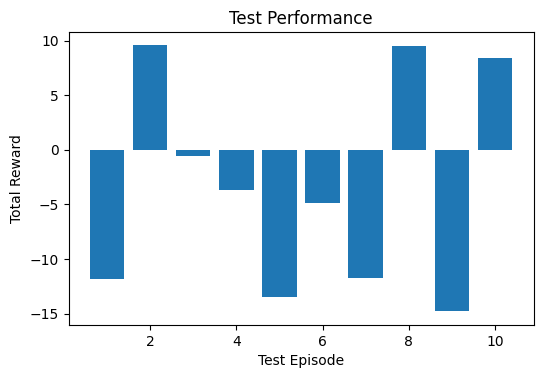

In [32]:
test_agent(opponent = h_env.BasicOpponent(weak=False), opponent_name = "non_weak", agent_name = "prio_agent")

In [ ]:
test_episodes = len(SEEDS_TEST)
test_rewards = []

opponent = copy.deepcopy(agent)
#opponent.Q.load(env_name, name = "episode_1500")

max_steps = 30000

for episode in range(test_episodes):

    state, _ = env.reset(seed = SEEDS_TEST[episode])
    state = state[0] if isinstance(state, tuple) else state  # Handle Gymnasium compatibility

    obs_agent2 = env.obs_agent_two()
    obs_agent2 = obs_agent2[0] if isinstance(obs_agent2, tuple) else obs_agent2

    total_reward = 0

    frames = []
    
    for t in range(max_steps):

        done = False

        frame = env.render(mode = "rgb_array")
        if frame is not None:
            frames.append(frame)

        a1 = agent.act(state, eps = 0.0)
        a2 = opponent.act(obs_agent2)

        if(USE_MORE_ACTIONS):
            a1_cont = MORE_ACTIONS[a1]
            a2 = MORE_ACTIONS[a2]
        else: 
            a1_cont = env.discrete_to_continous_action(a1)
            a2 = env.discrete_to_continous_action(a2)

        full_action = np.hstack([a1_cont, a2])

        next_state, reward, done, truncated, _ = env.step(full_action)
        
        total_reward += reward

        state = next_state
        obs_agent2 = env.obs_agent_two()

        if done or truncated: break

    test_rewards.append(total_reward)
    print(f"Test Episode {episode+1}, Total Reward: {total_reward}")
    
    if frames:
        os.makedirs(f"{env_name}/test_gifs/selfplay", exist_ok=True)
        imageio.mimsave(f"{env_name}/test_gifs/selfplay/test_episode_{episode+1}.gif", frames, fps=30)

env.close()

sf.save_test_results(env_name, test_rewards, name = "test_results_selfplay")

Test Episode 1, Total Reward: 7.831746649972516
Test Episode 2, Total Reward: -5.5722034239110165
Test Episode 3, Total Reward: -12.279143970067704


KeyboardInterrupt: 